# emotion recognition from speech

--- 
include libraries

In [2]:
import numpy as np
import os, sys, csv
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn import metrics 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
import matplotlib.pyplot as plt

from IPython.display import Audio
%matplotlib inline

---
## Prepare data and extract features using OpenSMILE :)

---

### Database: Berlin emotional database (free) 7 emotions
The data can be downloaded from http://emodb.bilderbar.info/index-1024.html

Code of emotions

W->Anger->Wut

L->Boredom->Langeweile

E->Disgust->Ekel

A->Anxiety/Fear->Angst

F->Happiness->Freude

T->Sadness->Trauer

N->Neutral

---
OpenSMILE :) toolkit for feature extraction from speech:
It can be downloaded from http://audeering.com/technology/opensmile/

In [3]:
PATH_AUDIO='C:/Users/elmon/Desktop/work/databases/Berlin/wav/'
PATH_OPENSMILE='C:/Users/elmon/Desktop/work/openSMILE-2.1.0/bin/Win32/SMILExtract_Release.exe'
CONFIG_FILE_OPENSMILE='C:/Users/elmon/Desktop/work/openSMILE-2.1.0/config/IS13_ComParE.conf'
TXT_OUT='C:/Users/elmon/Desktop/work/databases/Berlin/temp.csv'
n_jobs=4

hf=os.listdir(PATH_AUDIO)
hf.sort()
Features=[]

labelsd='WLEAFTN'

labelshl=  [0, 1, 0, 0, 0, 1, 1] # 0 high arousal emotion, 1 low arousal emotions
labelspn=  [0, 0, 0, 0, 1, 0, 1] # 0 negative valence emotion, 1 positive valence emotion
labelshlpn=[0, 1, 0, 0, 2, 1, 3] # 0 negative and high arousal, 1 negative and low arousal, 2 positive and high arousal, 3 positive and low arousal

LabelsHL=np.zeros(len(hf))
LabelsNP=np.zeros(len(hf))
LabelsHLPN=np.zeros(len(hf))
for j in range(len(hf)):
    name_file=hf[j]
    
    command=PATH_OPENSMILE+' -C '+CONFIG_FILE_OPENSMILE+' -I '+PATH_AUDIO+name_file+' -O '+TXT_OUT
    os.system(command)
    #print(command)
    f = open(TXT_OUT, 'rt')
    reader = csv.reader(f)
    for row in reader:
        feat=row
    feat=feat[1:len(feat)-1]
    f.close()
    feat_ar=np.asarray(feat)
    Features.append(feat_ar)
    
    label=hf[j][5]
    poslabel=labelsd.find(label)
    LabelsHL[j]=labelshl[poslabel]
    LabelsNP[j]=labelspn[poslabel]
    LabelsHLPN[j]=labelshlpn[poslabel]
    print(name_file, LabelsHL[j], LabelsNP[j], LabelsHLPN[j], j)
    
np.savetxt('./Features.txt', np.asarray(Features, dtype=np.float64), fmt='%s')   

Features=np.loadtxt('./Features.txt')
        

03a01Fa.wav 0.0 1.0 2.0 0
03a01Nc.wav 1.0 1.0 3.0 1
03a01Wa.wav 0.0 0.0 0.0 2
03a02Fc.wav 0.0 1.0 2.0 3
03a02Nc.wav 1.0 1.0 3.0 4
03a02Ta.wav 1.0 0.0 1.0 5
03a02Wb.wav 0.0 0.0 0.0 6
03a02Wc.wav 0.0 0.0 0.0 7
03a04Ad.wav 0.0 0.0 0.0 8
03a04Fd.wav 0.0 1.0 2.0 9
03a04Lc.wav 1.0 0.0 1.0 10
03a04Nc.wav 1.0 1.0 3.0 11
03a04Ta.wav 1.0 0.0 1.0 12
03a04Wc.wav 0.0 0.0 0.0 13
03a05Aa.wav 0.0 0.0 0.0 14
03a05Fc.wav 0.0 1.0 2.0 15
03a05Nd.wav 1.0 1.0 3.0 16
03a05Tc.wav 1.0 0.0 1.0 17
03a05Wa.wav 0.0 0.0 0.0 18
03a05Wb.wav 0.0 0.0 0.0 19
03a07Fa.wav 0.0 1.0 2.0 20
03a07Fb.wav 0.0 1.0 2.0 21
03a07La.wav 1.0 0.0 1.0 22
03a07Nc.wav 1.0 1.0 3.0 23
03a07Wc.wav 0.0 0.0 0.0 24
03b01Fa.wav 0.0 1.0 2.0 25
03b01Lb.wav 1.0 0.0 1.0 26
03b01Nb.wav 1.0 1.0 3.0 27
03b01Td.wav 1.0 0.0 1.0 28
03b01Wa.wav 0.0 0.0 0.0 29
03b01Wc.wav 0.0 0.0 0.0 30
03b02Aa.wav 0.0 0.0 0.0 31
03b02La.wav 1.0 0.0 1.0 32
03b02Na.wav 1.0 1.0 3.0 33
03b02Tb.wav 1.0 0.0 1.0 34
03b02Wb.wav 0.0 0.0 0.0 35
03b03Nb.wav 1.0 1.0 3.0 36
03b03Tc.wav

## Define functions to classify

In [10]:
def classSVMemotions(Features, Labels, plot=True):
        
    Cv=[1e-5,1e-4, 1e-3, 1e-2, 0.1,1,10,100,1000]
    gammav=[1e-5,1e-4, 1e-3, 1e-2, 0.1,1,10, 100,1000]
    Features[np.isnan(Features)]=0
    NumSpeakers=Features.shape[0]
    
    # perform Factor Analysis to reduce the dimension of the feature space 
    

    fa = FactorAnalysis(n_components=Ncomp)
    Features=fa.fit_transform(Features)
    
    MatTrain, MatTest, LabTrain, LabTest = train_test_split(Features, Labels, test_size=0.30, random_state=42)
    scaler = preprocessing.StandardScaler().fit(MatTrain) # estandarizacion de las matrices (media cero, desviacion estandar 1)
    MatTrain=scaler.transform(MatTrain) 
    MatTest=scaler.transform(MatTest)
    Results=[]


    print(MatTrain.shape, MatTest.shape, LabTrain.shape, LabTest.shape)
    
    clf = SVC() # Initialize SVM
    parameters={'C':Cv, 'gamma':gammav, 'kernel':['rbf'], 'class_weight':['balanced']} # parameters for grid-search
        
    cls_cv = GridSearchCV(clf, parameters, cv=9, n_jobs=n_jobs) # grid-search
    cls_cv.fit(MatTrain, LabTrain) # train the SVM
    accDev= cls_cv.best_score_ # validation accuracy
    Copt=cls_cv.best_params_.get('C') # best C
    gammaopt=cls_cv.best_params_.get('gamma') # best gamma
    
        
    cls=SVC(kernel='rbf', C=Copt, gamma=gammaopt, class_weight='balanced') # train the SVM with the optimal parameters
    cls.fit(MatTrain, LabTrain)
    labeslTest_est=cls.predict(MatTest) # test predictions
    acc=metrics.accuracy_score(LabTest, labeslTest_est)
    cm=metrics.confusion_matrix(LabTest, labeslTest_est)
    if len(np.unique(LabTest))==2:
        score_test=cls.decision_function(MatTest)
        AUC=metrics.roc_auc_score(LabTest, score_test)
        print(AUC)
    else:
        AUC=acc
    
    if plot:
        Matplot=MatTest[:,0:2]
        plt.figure(figsize=(10, 10)) 
        
        xx, yy = np.meshgrid(np.linspace(np.min(Matplot), np.max(Matplot), 500),
                np.linspace(np.min(Matplot), np.max(Matplot), 500))
        # plot the decision function for each datapoint on the grid
        Z = cls.decision_function(np.c_[xx.ravel(), yy.ravel()])
        
        Z = Z.reshape(xx.shape)

        plt.imshow(Z, interpolation='nearest',
            extent=(xx.min(), xx.max(), yy.min(), yy.max()), aspect='auto',
            origin='lower', cmap=plt.cm.PuOr_r)
        plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                linetypes='--')
        plt.scatter(Matplot[np.where(LabTest==0)[0], 0], Matplot[np.where(LabTest==0)[0], 1], s=70, c='0.1', cmap=plt.cm.PuOr_r, label='Class 0')
        plt.scatter(Matplot[np.where(LabTest==1)[0], 0], Matplot[np.where(LabTest==1)[0], 1], s=70, c='0.9', cmap=plt.cm.PuOr_r, label='Class 1')            
        plt.xlabel('C='+str(Copt)+' $\gamma$='+str(gammaopt)+' acc='+str(AUC), fontsize=18)   
        plt.legend()
        plt.xlim(-2,4)
        plt.ylim(-2,4)
        plt.show()

        #plt.show()
    return accDev, AUC, cm, cls, scaler, fa


## Exercise 1. High vs. low arousal emotions

(535, 6373)
222.0
(374, 2) (161, 2) (374,) (161,)
0.946359536082


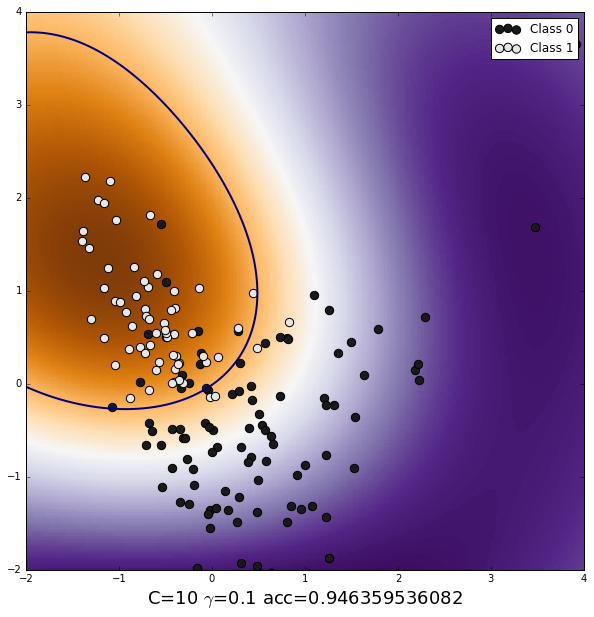

validation accuracy 0.885026737968
test accuracy 0.946359536082
Confusion Matrix [[83 14]
 [ 5 59]]


In [11]:
Features=np.asarray(Features, dtype=np.float64)
print(Features.shape)
#a=np.isnan(Features)
print(np.sum(LabelsHL))
Ncomp=2
accDev, acctest, cm, clsHL, scalerhl, fahl=classSVMemotions(Features, LabelsHL)
print('validation accuracy', accDev)
print('test accuracy', acctest)
print('Confusion Matrix', cm)

## Exercise 2. Positive vs. Negative emotions

(535, 6373)
150.0
(374, 2) (161, 2) (374,) (161,)
0.593294460641


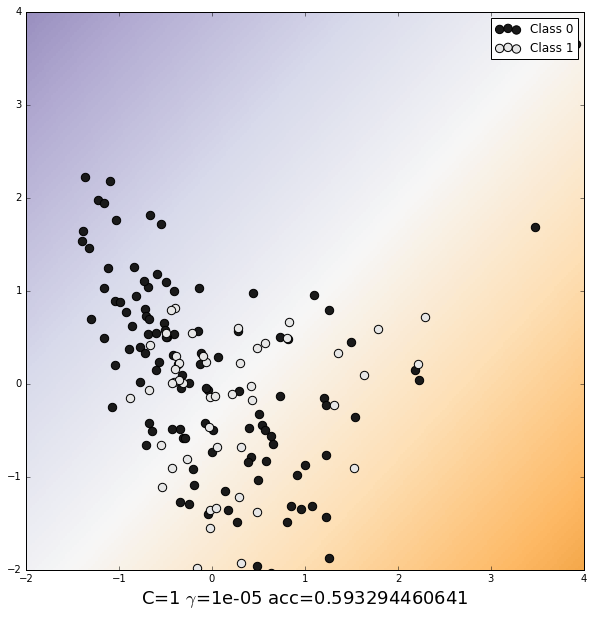

validation accuracy 0.729946524064
test accuracy 0.593294460641
Confusion Matrix [[  0 112]
 [  0  49]]


In [12]:
Features=np.asarray(Features, dtype=np.float64)
print(Features.shape)
#a=np.isnan(Features)
print(np.sum(LabelsNP))
Ncomp=2
accDev, acctest, cm, clsNP, scalerpn, fapn=classSVMemotions(Features, LabelsNP, plot=True)
print('validation accuracy', accDev)
print('test accuracy', acctest)
print('Confusion Matrix', cm)

## Positive vs. Negative emotions with 100 componets of Factor Analysis

In [13]:
Features=np.asarray(Features, dtype=np.float64)
print(Features.shape)
#a=np.isnan(Features)
print(np.sum(LabelsNP))
Ncomp=100
accDev, acctest, cm, clsNP, scalerpn, fapn=classSVMemotions(Features, LabelsNP, plot=False)
print('validation accuracy', accDev)
print('test accuracy', acctest)
print('Confusion Matrix', cm)

(535, 6373)
150.0
(374, 100) (161, 100) (374,) (161,)
0.759293002915
validation accuracy 0.767379679144
test accuracy 0.759293002915
Confusion Matrix [[102  10]
 [ 29  20]]


## Exercise 3. Classification of multiple emotions

In [14]:
Features=np.asarray(Features, dtype=np.float64)
print(Features.shape)
#a=np.isnan(Features)
print(np.sum(LabelsNP))
Ncomp=100
accDev, acctest, cm, clsNPHL, scalerpnhl, fapnhl=classSVMemotions(Features, LabelsHLPN, plot=False)
print('validation accuracy', accDev)
print('test accuracy', acctest)
print('Confusion Matrix', cm)

(535, 6373)
150.0
(374, 100) (161, 100) (374,) (161,)
validation accuracy 0.66577540107
test accuracy 0.633540372671
Confusion Matrix [[64  3  3  0]
 [14 22  0  6]
 [16  1  8  2]
 [ 9  4  1  8]]


# test of some audios from other dataset

In [16]:
file_audio='C:/Users/elmon/Desktop/work/databases/IEMOCAP_audio/audios/Ses05M_script01_1_F016.wav'
#file_audio='C:/Users/elmon/Desktop/work/databases/IEMOCAP_audio/audios/Ses05M_script01_1_F016.wav'

# extract features using openSMILE
command=PATH_OPENSMILE+' -C '+CONFIG_FILE_OPENSMILE+' -I '+file_audio+' -O '+TXT_OUT
    
os.system(command)
print(command)
f = open(TXT_OUT, 'rt')
reader = csv.reader(f)
for row in reader:
    feat=row
feat=feat[1:len(feat)-1]
f.close()
features=np.asarray(feat, dtype=np.float64).reshape(1, -1)



featuressc=fahl.transform(features)
featuressc=scalerhl.transform(featuressc)

class_pred=clsHL.predict(featuressc)

if class_pred==0:
    print('High Arousal emotion')
else:
    print('Low Arousal emotion')

featuressc=fapn.transform(features)
featuressc=scalerpn.transform(featuressc)

    
class_pred=clsNP.predict(featuressc)

if class_pred==0:
    print('Negative valence emotion')
else:
    print('Positive valence emotion')
Audio(file_audio)

C:/Users/elmon/Desktop/work/openSMILE-2.1.0/bin/Win32/SMILExtract_Release.exe -C C:/Users/elmon/Desktop/work/openSMILE-2.1.0/config/IS13_ComParE.conf -I C:/Users/elmon/Desktop/work/databases/IEMOCAP_audio/audios/Ses05M_script01_1_F016.wav -O C:/Users/elmon/Desktop/work/databases/Berlin/temp.csv
Low Arousal emotion
Negative valence emotion
